# Toy study: Gaussian on a circle

## Setup

In [1]:
%matplotlib inline

import sys
from collections import OrderedDict
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import torch
from torch.utils.data import TensorDataset
import logging

sys.path.append("../../")
from manifold_flow import transforms, utils, distributions
from experiments import training
from manifold_flow.flows import Flow, ManifoldFlow, ProbabilisticAutoEncoder
from manifold_flow import nn as nn_
from experiments.datasets import SphericalGaussianSimulator
from experiments.architectures.vector_transforms import create_vector_transform, create_vector_encoder, create_vector_decoder
import plot_settings as ps

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


In [2]:
ps.setup()

### Settings

In [3]:
epochs = 12
n_train = 10000
epsilon = 0.01
train = False

### Data

In [4]:
simulator = SphericalGaussianSimulator(latent_dim=1, data_dim=2, epsilon=epsilon)
x_sim = simulator.sample(n_train)
x_sim_tensor = torch.from_numpy(x_sim)
train_dataset = TensorDataset(x_sim_tensor, x_sim_tensor)

## Set up models

In [5]:
labels = OrderedDict()
labels["truth"] = "Truth"
labels["sf"] = "AF"
labels["pie"] = "PIE (manifold)"
labels["pie_full"] = "PIE"
labels["pae"] = "PAE"
labels["mf"] = "FOM"
labels["mlfl"] = r"$\mathcal{M}$-flow (S)"
labels["mlfa"] = r"$\mathcal{M}$-flow (M/D)"
labels["mlfot"] = r"$\mathcal{M}$-flow (OT)"
labels["mlfae"] = r"$\mathcal{M}$-flow (AE)"


### Standard flow

In [6]:
sf = Flow(
    data_dim=2,
    transform=create_vector_transform(2, 10, base_transform_type="affine-coupling"),
)

if train:
    trainer = training.trainer.ForwardTrainer(sf)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
    )
    torch.save(sf.state_dict(), "../data/models/sf_toy.pt")
else:
    sf.load_state_dict(torch.load("../data/models/sf_toy.pt"))

10:56 manifold_flow.flows.base       INFO    Model has 0.4 M parameters (0.4 M trainable) with an estimated size of 1.6 MB


### Manifold flow (with specified manifold)

In [7]:
mf = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=transforms.SphericalCoordinates(n=1, r0=1., azimuthal_offset=-0.5*np.pi)
)

if train:
    trainer = training.trainer.ForwardTrainer(mf)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
        forward_kwargs={"mode":"mf"}
    )
    torch.save(mf.state_dict(), "../data/models/mf_toy.pt")
else:
    mf.load_state_dict(torch.load("../data/models/mf_toy.pt"))

10:56 manifold_flow.flows.base       INFO    Model has 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 MB
10:56 manifold_flow.flows.manifold_f INFO      Outer transform: 0.0 M parameters
10:56 manifold_flow.flows.manifold_f INFO      Inner transform: 0.0 M parameters


### PAE

In [8]:
pae = ProbabilisticAutoEncoder(
    data_dim=2,
    latent_dim=1,
    encoder=create_vector_encoder(2, 1, num_blocks=5),
    decoder=create_vector_decoder(2, 1, num_blocks=5),
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
)

if train:
    trainer = training.trainer.ForwardTrainer(pae)
    trainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[1.],
        epochs=epochs // 2,
        parameters=list(pae.encoder.parameters()) + list(pae.decoder.parameters())
    )
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs // 2,
        parameters=list(pae.inner_transform.parameters())
    )
    torch.save(pae.state_dict(), "../data/models/pae_toy.pt")
else:
    pae.load_state_dict(torch.load("../data/models/pae_toy.pt"))
    

10:56 manifold_flow.flows.base       INFO    Model has 0.2 M parameters (0.2 M trainable) with an estimated size of 0.8 MB
10:56 manifold_flow.flows.pae        INFO      Encoder:         0.1 M parameters
10:56 manifold_flow.flows.pae        INFO      Decoder:         0.1 M parameters
10:56 manifold_flow.flows.pae        INFO      Inner transform: 0.0 M parameters


### PIE

In [9]:
pie = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    outer_transform=create_vector_transform(2, 5, base_transform_type="affine-coupling"),
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    pie_epsilon=0.1,
)

if train:
    trainer = training.trainer.ForwardTrainer(pie)
    trainer.train(
        train_dataset,
        [training.losses.nll],
        loss_weights=[1.],
        epochs=epochs,
        forward_kwargs={"mode":"pie"}
    )
    torch.save(pie.state_dict(), "../data/models/pie_toy.pt")
else:
    pie.load_state_dict(torch.load("../data/models/pie_toy.pt"))
    

10:56 manifold_flow.flows.base       INFO    Model has 0.2 M parameters (0.2 M trainable) with an estimated size of 0.8 MB
10:56 manifold_flow.flows.manifold_f INFO      Outer transform: 0.2 M parameters
10:56 manifold_flow.flows.manifold_f INFO      Inner transform: 0.0 M parameters


### M-flow (alternating M/D training)

In [10]:
mlfa = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(2, 5, base_transform_type="affine-coupling")
)

if train:
    trainer = training.ForwardTrainer(mlfa)
    metatrainer = training.AlternatingTrainer(mlfa, trainer, trainer)
    metatrainer.train(
        train_dataset,
        loss_functions=[training.losses.mse, training.losses.nll],
        loss_function_trainers=[0, 1],
        loss_labels=["MSE", "NLL"],
        loss_weights=[100., 0.1],
        epochs=epochs,
        parameters=[mlfa.parameters(), mlfa.inner_transform.parameters()],
        trainer_kwargs=[{"forward_kwargs": {"mode": "projection"}}, {"forward_kwargs": {"mode": "pie"}}],
    )
    torch.save(mlfa.state_dict(), "../data/models/mlfa_toy.pt")
else:
    mlfa.load_state_dict(torch.load("../data/models/mlfa_toy.pt"))

10:56 manifold_flow.flows.base       INFO    Model has 0.2 M parameters (0.2 M trainable) with an estimated size of 0.8 MB
10:56 manifold_flow.flows.manifold_f INFO      Outer transform: 0.2 M parameters
10:56 manifold_flow.flows.manifold_f INFO      Inner transform: 0.0 M parameters


### M-flow (OT training)

In [11]:
mlfot = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(2, 5, base_transform_type="affine-coupling")
)

if train:
    trainer = training.trainer.AdversarialTrainer(mlfot)
    trainer.train(
        train_dataset,
        [training.losses.make_sinkhorn_divergence()],
        loss_weights=[100.],
        epochs=epochs,
        batch_size=1000,
    )
    torch.save(mlfot.state_dict(), "../data/models/mlfot_toy.pt")
else:
    mlfot.load_state_dict(torch.load("../data/models/mlfot_toy.pt"))

10:56 manifold_flow.flows.base       INFO    Model has 0.2 M parameters (0.2 M trainable) with an estimated size of 0.8 MB
10:56 manifold_flow.flows.manifold_f INFO      Outer transform: 0.2 M parameters
10:56 manifold_flow.flows.manifold_f INFO      Inner transform: 0.0 M parameters


### M-flow (simple autoencoder training)

In [12]:
mlfae = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(2, 5, base_transform_type="affine-coupling")
)

if train:
    trainer = training.trainer.ForwardTrainer(mlfae)
    trainer.train(
        train_dataset,
        [training.losses.mse],
        loss_weights=[100.],
        epochs=epochs,
        forward_kwargs={"mode":"projection"}
    )
    torch.save(mlfae.state_dict(), "../data/models/mlfae_toy.pt")
else:
    mlfae.load_state_dict(torch.load("../data/models/mlfae_toy.pt"))

10:56 manifold_flow.flows.base       INFO    Model has 0.2 M parameters (0.2 M trainable) with an estimated size of 0.8 MB
10:56 manifold_flow.flows.manifold_f INFO      Outer transform: 0.2 M parameters
10:56 manifold_flow.flows.manifold_f INFO      Inner transform: 0.0 M parameters


## Evaluate the models

In [13]:
sf.eval()
mf.eval()
pie.eval()
mlfa.eval()
mlfot.eval()
mlfae.eval()

None

### Sample from models

In [14]:
x_gen = OrderedDict()

x_gen["truth"] = x_sim[:1000]
x_gen["sf"] = sf.sample(n=1000).detach().numpy()
x_gen["mf"] = mf.sample(n=1000).detach().numpy()
x_gen["pie"] = pie.sample(n=1000).detach().numpy()
x_gen["pie_full"] = pie.sample(n=1000, sample_orthogonal=True).detach().numpy()
x_gen["pae"] = pae.sample(n=1000).detach().numpy()
x_gen["mlfa"] = mlfa.sample(n=1000).detach().numpy()
x_gen["mlfot"] = mlfot.sample(n=1000).detach().numpy()
x_gen["mlfae"] = mlfae.sample(n=1000).detach().numpy()


### Evaluate model likelihood over data space

In [15]:
res = 200
boundary = 1.5
im_extent = boundary + 0.5 * (2.*boundary/(res - 1))

x_range = np.linspace(-boundary, boundary, res)
y_range = np.linspace(-boundary, boundary, res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

logp_grid = OrderedDict()
logp_grid["truth"] = simulator.log_density(x_grid).reshape((res, res))
logp_grid["truth"][~np.isfinite(logp_grid["truth"])] = -1000000.
logp_grid["sf"] = sf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
logp_grid["pie_full"] = pie.log_prob(x_grid_tensor, mode="pie").detach().numpy().reshape((res, res))


../../experiments/datasets/spherical_simulator.py:106: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


In [16]:
def likelihood_along_manifold(model, mode="mf", zmin=-5., zmax=5., n_samples=100, epsilon=0.01, max_insert=10000):
    # Sample
    u = torch.linspace(zmin, zmax, n_samples).view(-1,1)
    x = model.sample(n=n_samples, u=u).detach().numpy()
    u = u.numpy().flatten()
    
    def in_box(x):
        return np.abs(x[0]) < 1.5 and np.abs(x[1]) < 1.5
    
    # Interpolate
    x_interpol = [x[0]]
    for x_prev, x_now, u_prev, u_now  in zip(x[:-1], x[1:], u[:-1], u[1:]):
        
        # Check if we should generate more points in between
        distance = np.linalg.norm(x_now-x_prev)
        if distance > epsilon and (in_box(x_now) or in_box(x_prev)):
            n_insert = min(int(distance / epsilon), max_insert)
            u_insert = torch.linspace(u_prev, u_now, n_insert + 2)[1:-1].view(-1,1)
            x_insert = model.sample(n=n_insert, u=u_insert).detach().numpy()
            for x_ in x_insert:
                if in_box(x_):
                    x_interpol.append(x_)
            
        if in_box(x_now):
            x_interpol.append(x_now)
            
    x_interpol = np.array(x_interpol)

    # Evaluate likelihood
    log_probs = model.log_prob(torch.FloatTensor(x_interpol), mode=mode).detach().numpy()

    # Return
    return x_interpol, log_probs


logp_manifold, x_manifold = OrderedDict(), OrderedDict()
x_manifold["mf"], logp_manifold["mf"] = likelihood_along_manifold(mf)
# x_manifold["mlfl"], logp_manifold["mlfl"] = likelihood_along_manifold(mlfl)
x_manifold["mlfa"], logp_manifold["mlfa"] = likelihood_along_manifold(mlfa)
x_manifold["mlfot"], logp_manifold["mlfot"] = likelihood_along_manifold(mlfot)
x_manifold["mlfae"], logp_manifold["mlfae"] = likelihood_along_manifold(mlfae)
x_manifold["pie"], logp_manifold["pie"] = likelihood_along_manifold(pie)


### Calculate metrics for generated samples: mean distance from manifold, true likelihood

In [17]:
def generative_metrics(x, logp_min=-100., d_max=1., summary_fn=np.mean):
    logp_gen = simulator.log_density(x)
    logp_gen[(~np.isfinite(logp_gen)) + (logp_gen<logp_min)] = logp_min
    logp_summary = summary_fn(logp_gen)
    
    d_gen = np.abs(np.sum(x**2, axis=1)**0.5 - 1)
    d_gen[(~np.isfinite(d_gen)) + (d_gen>d_max)] = d_max
    d_summary = summary_fn(d_gen)
    
    return logp_summary, d_summary


logp_gen, d_gen = OrderedDict(), OrderedDict()

for key, val in x_gen.items():
    logp_gen[key], d_gen[key] = generative_metrics(x_gen[key])
    

print("Mean true log likelihood of samples generated from flows (higher is better):")
for key, val in logp_gen.items():
    print("  {:>10.10s}: {:>6.1f}".format(key, val))
    
print("Mean Euclidean distance between samples generated from flows and true manifold (lower is better):")
for key, val in d_gen.items():
    print("  {:>10.10s}: {:>6.4f}".format(key, val))
    

Mean true log likelihood of samples generated from flows (higher is better):
       truth:    2.0
          sf:  -86.0
          mf:    0.5
         pie:  -42.5
    pie_full:  -75.5
         pae:   -8.8
        mlfa:  -94.4
       mlfot:    0.6
       mlfae:  -32.8
Mean Euclidean distance between samples generated from flows and true manifold (lower is better):
       truth: 0.0081
          sf: 0.5801
          mf: 0.0000
         pie: 0.1667
    pie_full: 0.3058
         pae: 0.0289
        mlfa: 0.9211
       mlfot: 0.0089
       mlfae: 0.2197


### Visualize generated samples

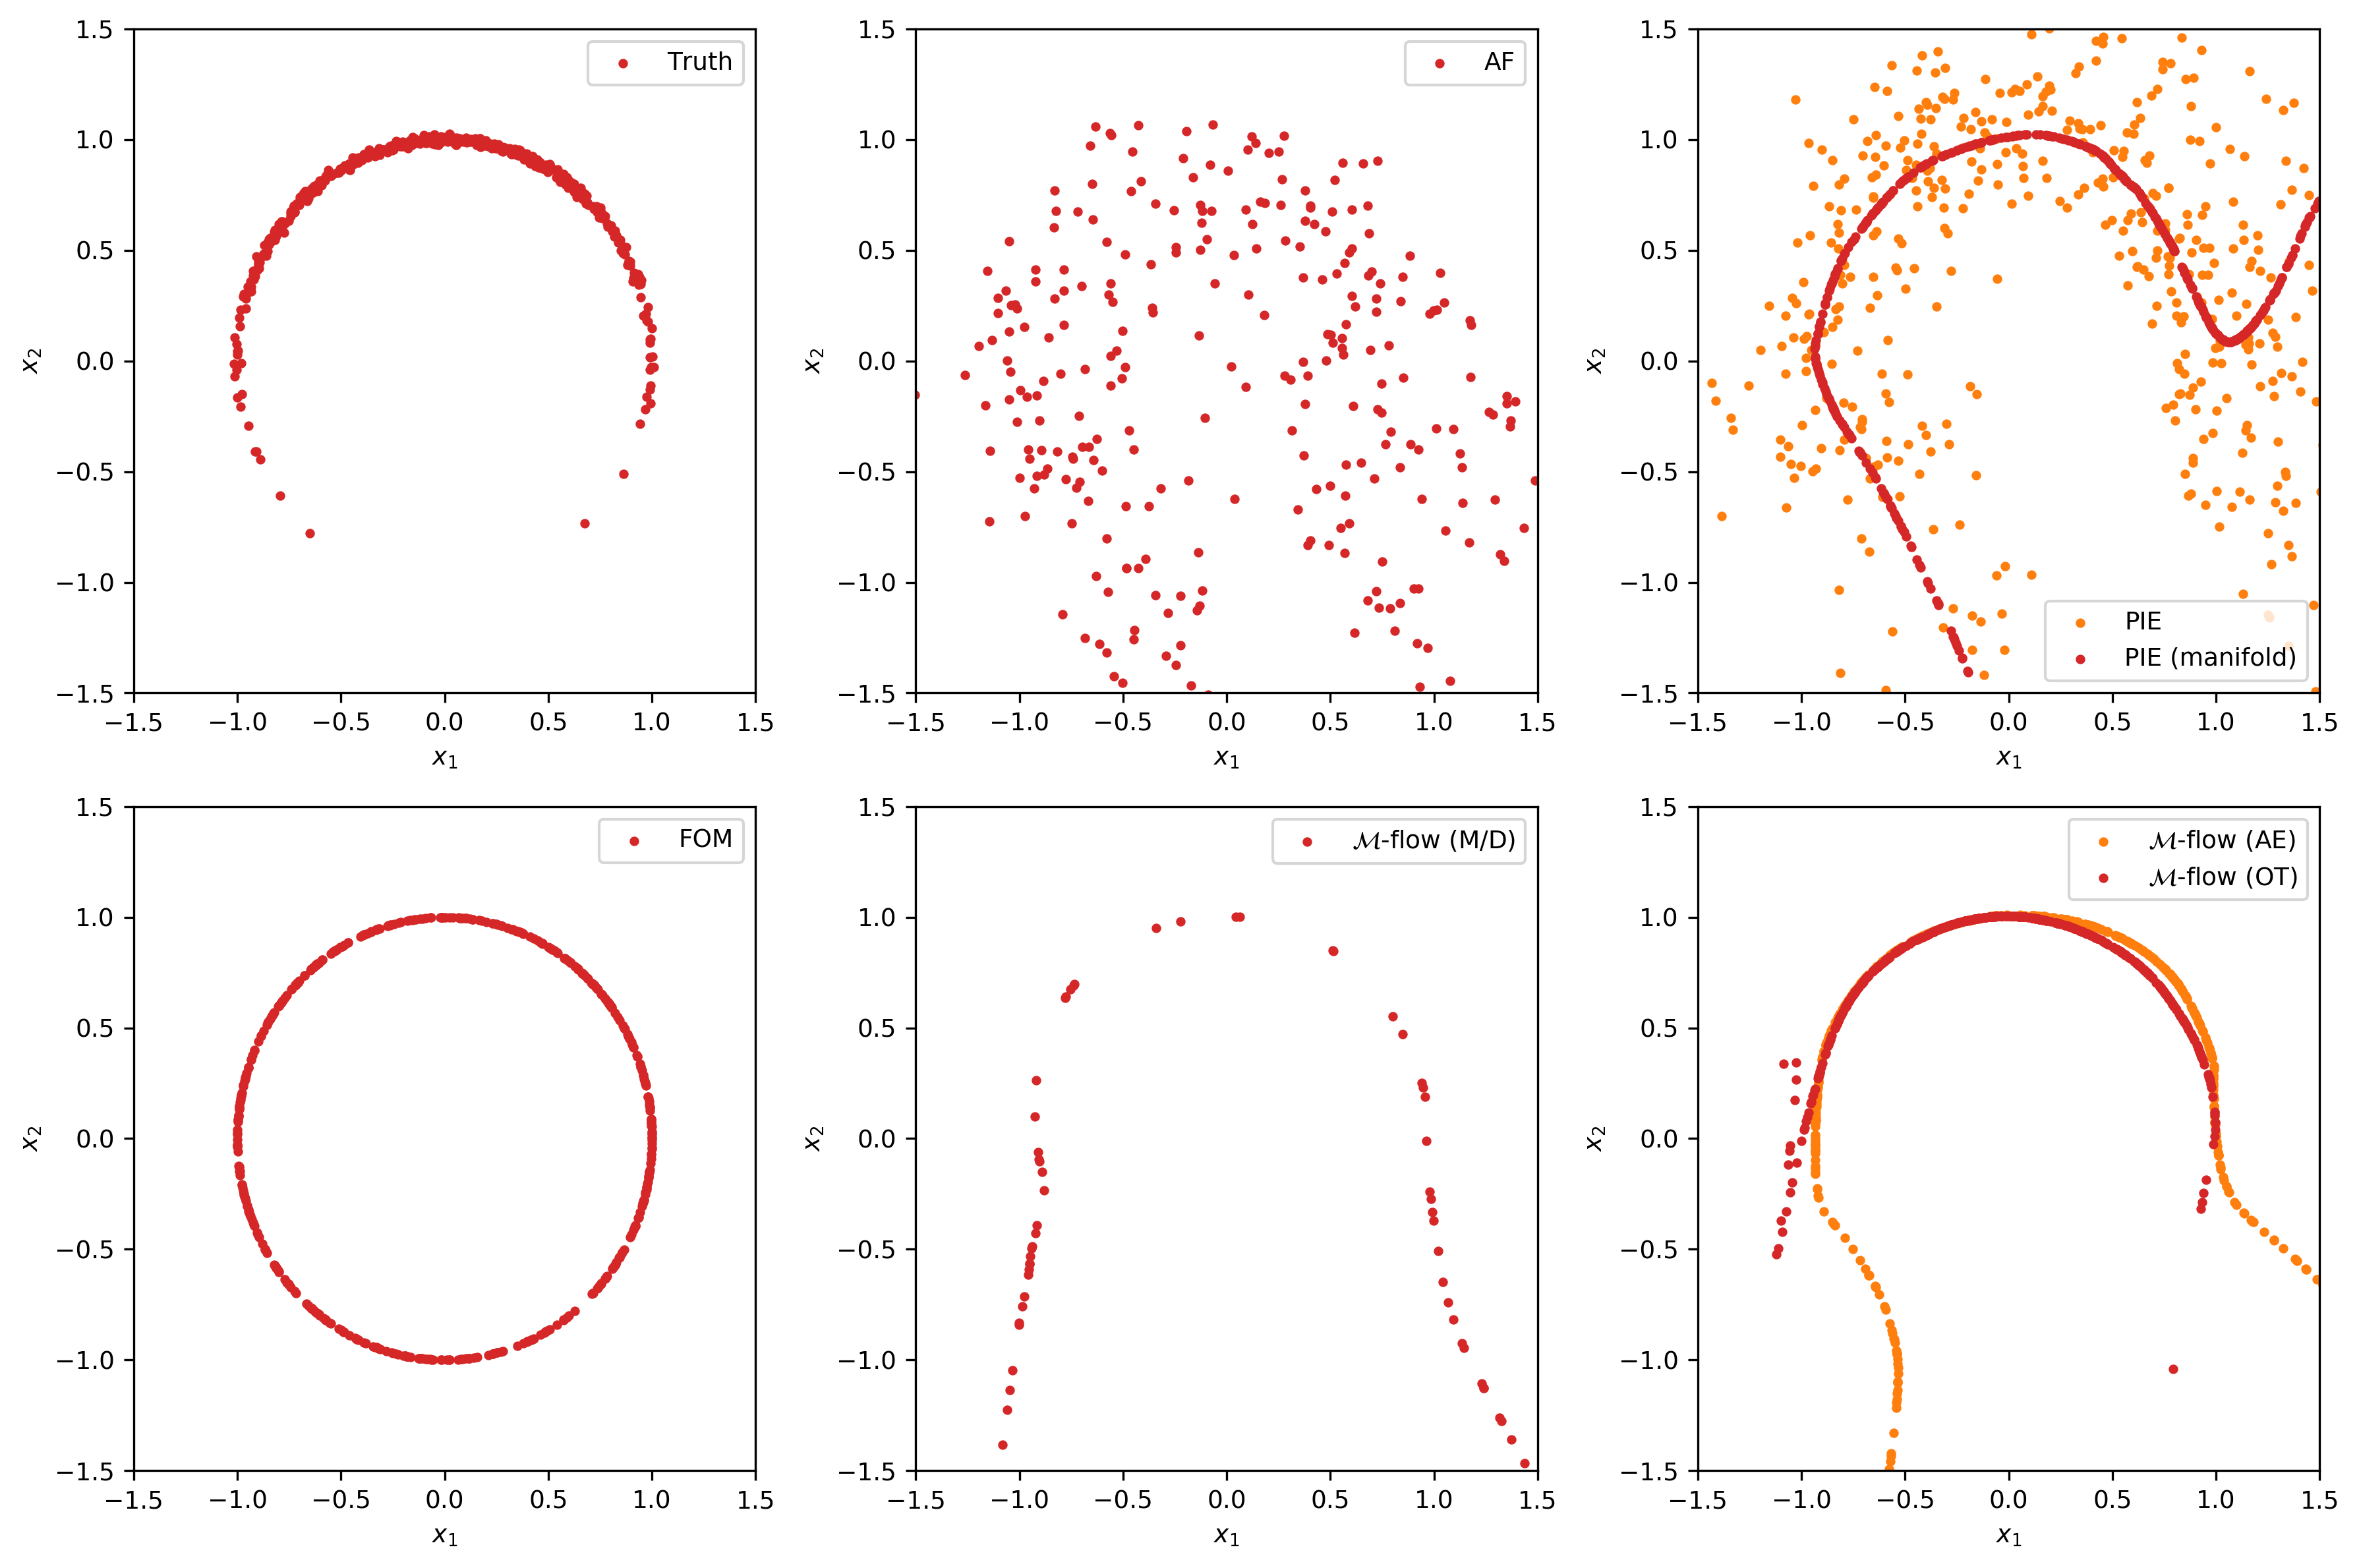

In [18]:
n = 500
show1 = ["truth", "sf", "pie", "mf", "mlfa", "mlfot"]
show2 = [None, None, "pie_full", None, None, "mlfae"]

fig = plt.figure(figsize=(4.*3,4.*2))

for i, (key, key2) in enumerate(zip(show1, show2)):
    ax = plt.subplot(2,3,i+1)
    
    if key2 is not None:
        plt.scatter(x_gen[key2][:n,0], x_gen[key2][:n,1], s=6., c="C1", label=labels[key2])
    plt.scatter(x_gen[key][:n,0], x_gen[key][:n,1], s=6., c="C3", label=labels[key])
    plt.legend()

    plt.xlim(-boundary, boundary)
    plt.ylim(-boundary, boundary)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")

plt.tight_layout()
plt.savefig("../figures/circle_generated_samples.pdf")


### Plot likelihoods

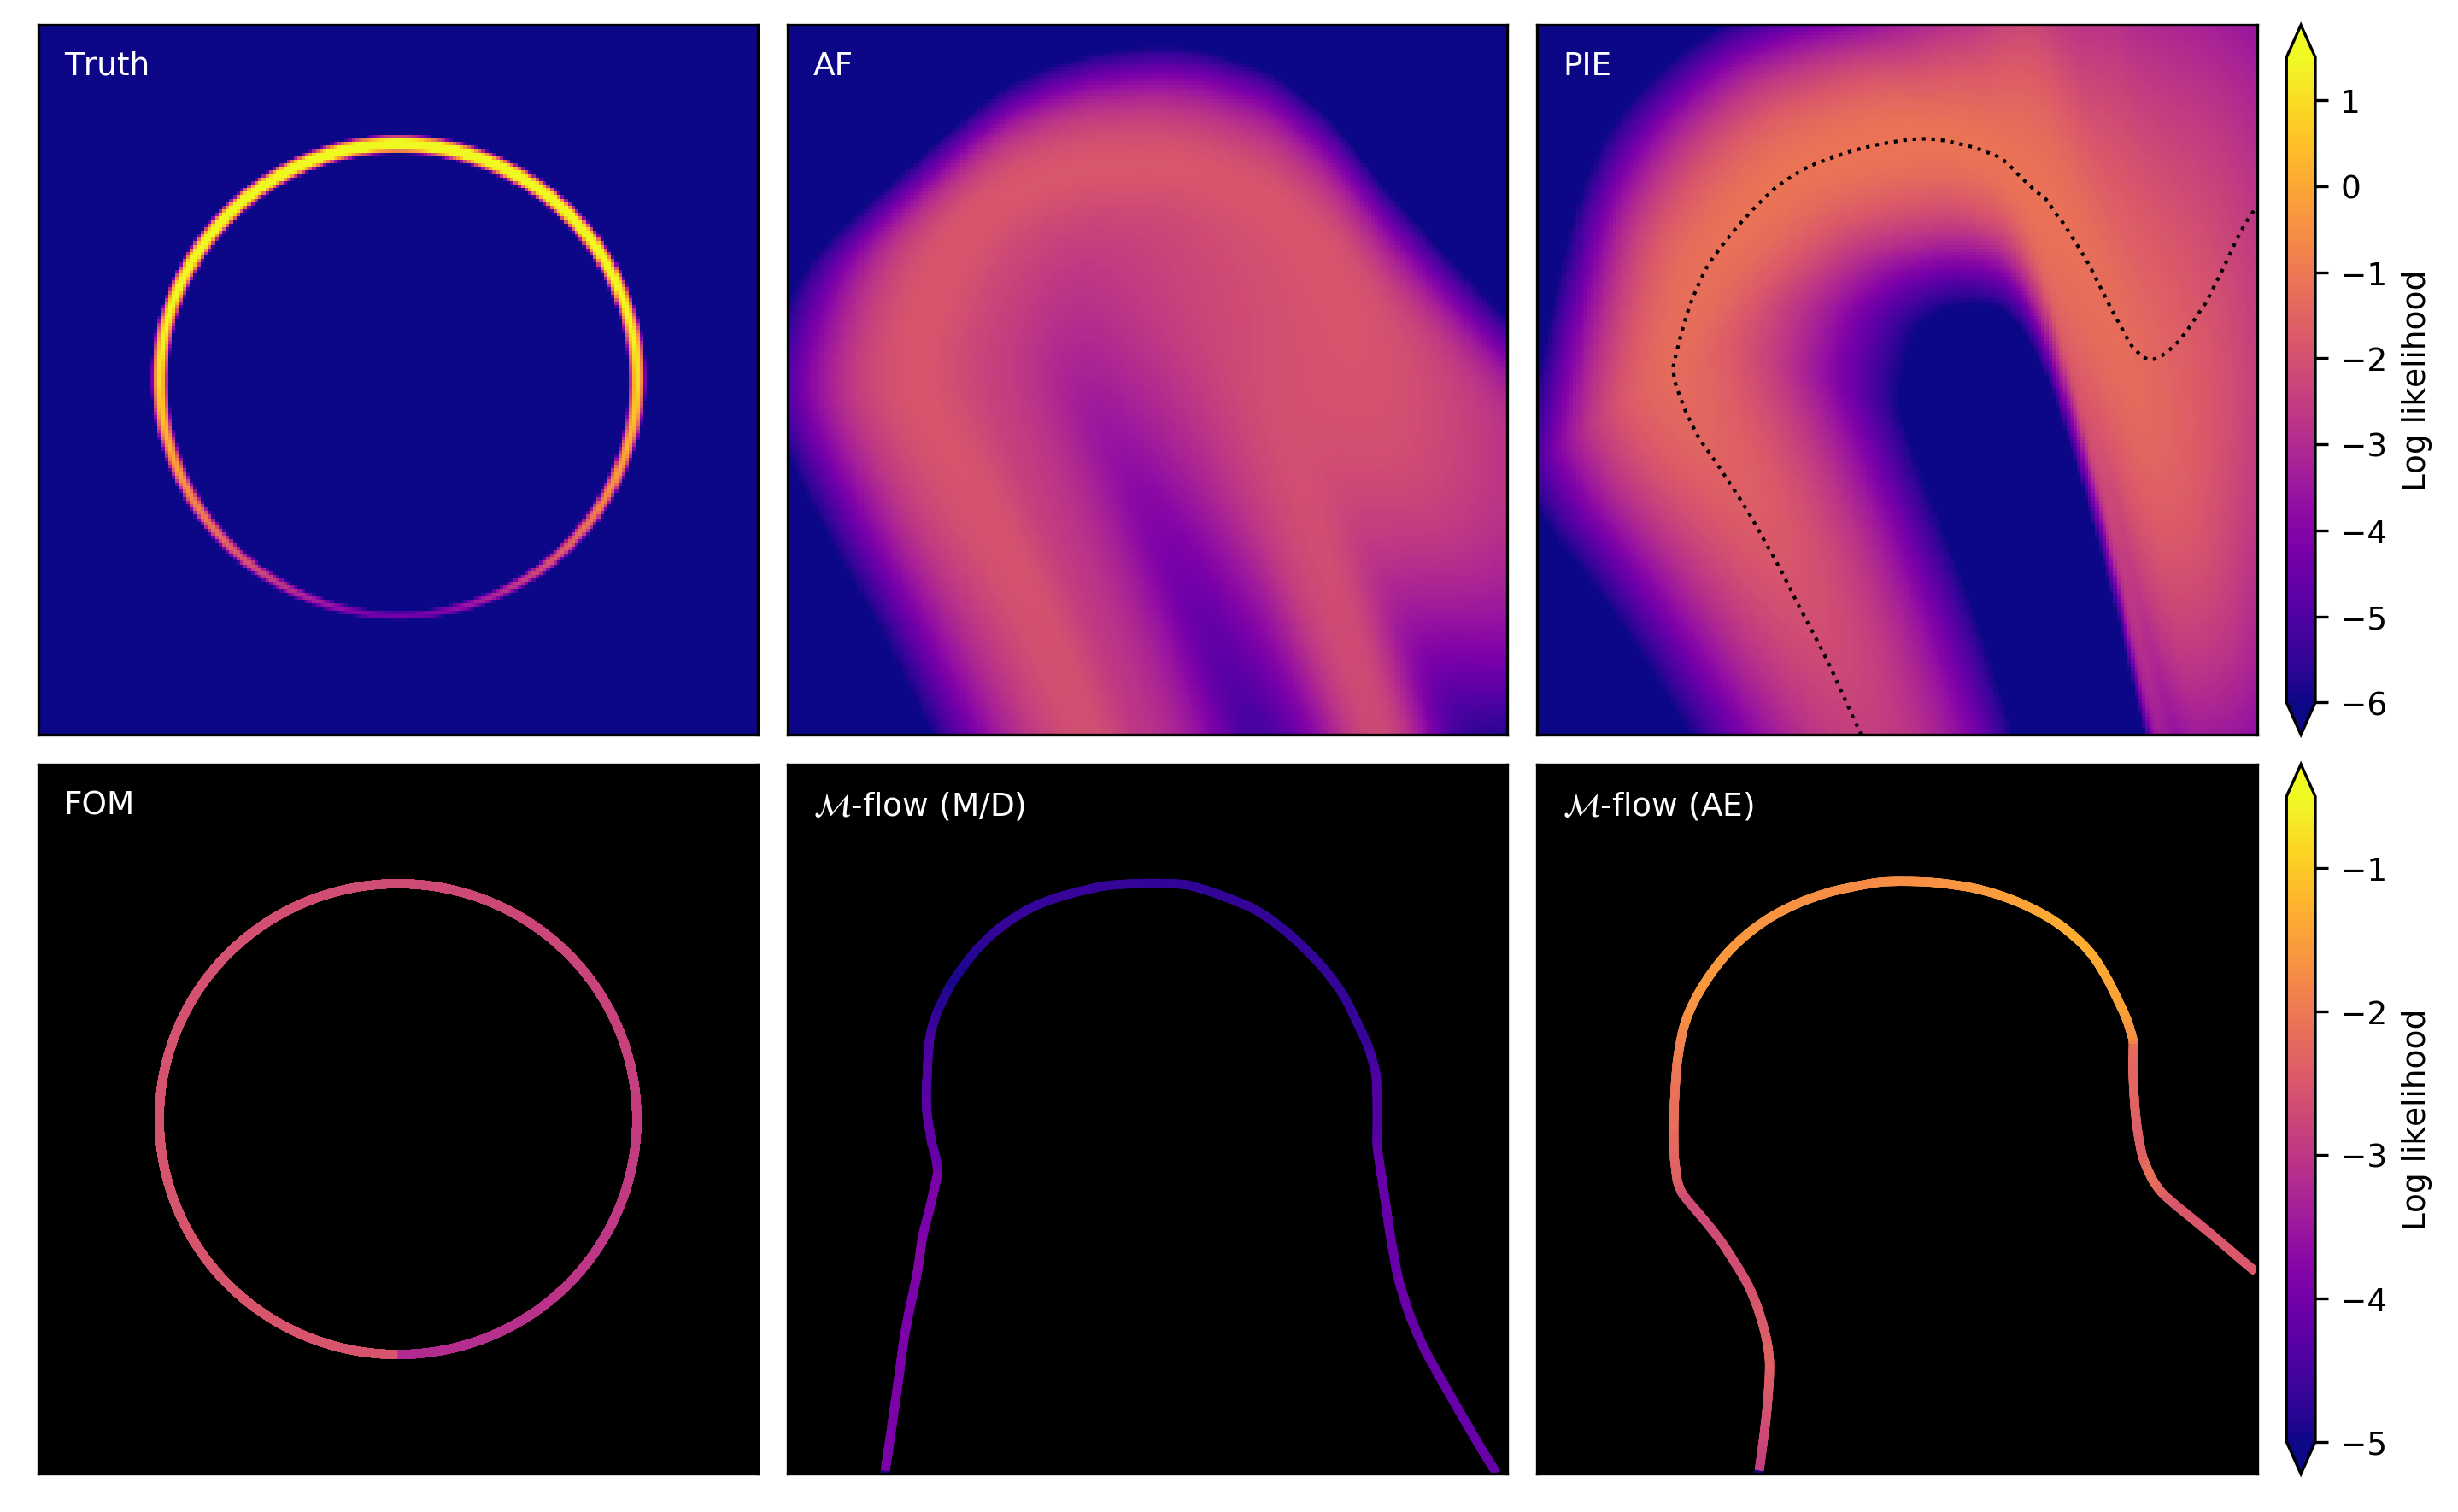

In [19]:
show = ["truth", "sf", "pie_full", "mf", "mlfa", "mlfae"]
cmins = [-6., -6., -6., -5., -5., -5.]
cmaxs = [1.5, 1.5, 1.5, -0.5, -0.5, -0.5]

label_kwargs={"ha":"left", "va":"top", "x":-1.4, "y":1.4, "fontsize":9., "fontweight":"500"}

fig, gs = ps.grid2_width(3, 2, small_margin=0.01, large_margin=0.085)

for i, (key, cmin, cmax) in enumerate(zip(show, cmins, cmaxs)):
    panel = i if i < 3 else i+1
    ax = plt.subplot(gs[panel])
    
    try:
        x = x_manifold[key]
        logp = logp_manifold[key]
        
        for increase_size in [0.01, 0.]:
            segments = np.concatenate([x[:-1,np.newaxis,:], x[1:,np.newaxis,:]], axis=1)
            segments = [
                [start - increase_size * (end - start)/np.linalg.norm(end - start),
                 end + increase_size * (end - start)/np.linalg.norm(end - start)]
                for (start, end) in segments
            ]
            lc = LineCollection(segments, cmap=ps.CMAP, norm=plt.Normalize(cmin, cmax))
            lc.set_array(np.clip(logp, cmin, cmax))
            lc.set_linewidth(2.5)
            im = ax.add_collection(lc)
        plt.text(s=labels[key], c=ps.COLOR_NEUTRAL4, **label_kwargs)
        
        ax.set_facecolor('black')

    except KeyError:
        logp = logp_grid[key]
        im = plt.imshow(
            np.clip(logp, cmin, cmax),
            extent=(-im_extent, im_extent, -im_extent, im_extent),
            origin="lower",
            cmap=ps.CMAP,
            norm=matplotlib.colors.Normalize(cmin, cmax),
            interpolation='nearest',
            aspect="auto"
        )
        
        if key=="pie_full":
            plt.plot(x_manifold["pie"][:,0], x_manifold["pie"][:,1], lw=1., ls=":", c=ps.COLOR_NEUTRAL1)
            
        plt.text(s=labels[key], c=ps.COLOR_NEUTRAL4, **label_kwargs)

    plt.xlim(-im_extent, im_extent)
    plt.ylim(-im_extent, im_extent)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
        
    if i in [0, 3]:
        ax = plt.subplot(gs[4*int(i>0) + 3])
        cbar = fig.colorbar(
            im,
            cax=ax,
            extend="both",
            ticks=[-6.,-5.,-4.,-3,-2,-1,0,1],
            #format=matplotlib.ticker.FuncFormatter(lambda x, _ : "{:.0f}".format(x**2))
        )
        cbar.set_label(r"Log likelihood")
        # ax.yaxis.set_label_coords(5., 0.5)
    
plt.savefig("../figures/circle_log_likelihood.pdf")
